In [103]:
import time
import sys

import numpy as np

from user_control import UserControl
from user_mobility.rpgm import ReferencePointGroupMobility
from drone_control import DroneControl
from drone_navigation.pso import PSO
from drone_navigation.k_means import KMeans
from visualization_3d import Visualization
from entity.antenna import Antenna

Text(0.5, 1.0, 'ABC123 vs $\\mathrm{ABC123}^{123}$')

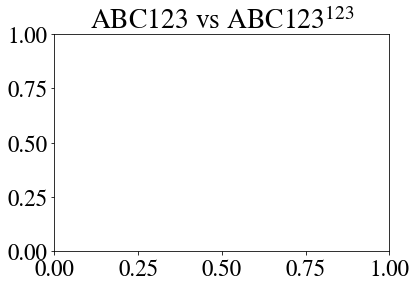

In [104]:
import matplotlib
from matplotlib import pyplot as plt
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['font.size'] = 23
matplotlib.rcParams.update({'font.size': 23})
matplotlib.pyplot.title(r'ABC123 vs $\mathrm{ABC123}^{123}$')

Text(0.5, 1.0, 'ABC123 vs $\\mathrm{ABC123}^{123}$')

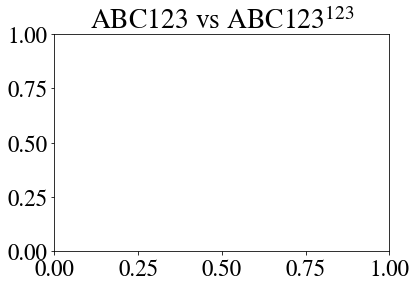

In [105]:
# НУЖНОЕ ДУБЛИРОВАНИЕ
import matplotlib
from matplotlib import pyplot as plt
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['font.size'] = 23
matplotlib.rcParams.update({'font.size': 23})
matplotlib.pyplot.title(r'ABC123 vs $\mathrm{ABC123}^{123}$')

In [106]:
# Initial data for simulation
simulation_params = {
    'area_x': 100,  # meters
    'area_y': 100,  # meters
    'max_simulation_time': 10,  # s
    'delta_t': 0.1,  # s
    'snr_threshold': 20,  # dB

    'average_runs': 100,

    # Initial data for users
    'users_number': 250,  # number
    'groups_number': 5,  # number
    'groups_limits': [50, 50, 50, 50, 50],  # array of numbers
    'users_speed': 2.4,  # m/s
    'users_height': 2,  # m
    'r_max_k': 1.,

    # Initial data for drones
    'drones_number': 5,  # number
    'drones_speed': [5, 5, 5, 5, 5],  # m/s
    'drone_t_upd': 3.0,  # seconds    # IF ZERO - DRONES UPDATE THEIR POSITION WHEN EVERY DRONE IS ON POSITION
    'drones_height': 20,  # m

    # Initial data for antenna
    'transmit_power': 24,  # dBm
    'transmission_bandwidth': 0.56 * 10 ** 9,  # Hz
    'carrier_frequency': 60 * 10 ** 9,  # Hz
    'receive_antenna_gain': 3,  # dBi
    'transmit_antenna_gain': 3,  # dBi
}

In [107]:
class DronesProject:
    def __init__(self, parameters):
        self.parameters = parameters
        self.simulation_time = parameters['max_simulation_time']
        self.delta_t = parameters['delta_t']
        self.drone_t_upd = parameters['drone_t_upd']
        self.total_time_steps = int(self.simulation_time / self.delta_t)
        self.users = np.array([])
        self.drones = np.array([])
        self.groups = np.array([])
        self.drones_paths = np.array([])
        self.drones_diagrams = np.array([])
        self.coverage = np.array([])
        self.coverage_pso = np.array([])
        self.coverage_kmeans = np.array([])
        self.coverage_twice_pso = np.array([])
        self.coverage_twice_kmeans = np.array([])
        self.user_mobility = ReferencePointGroupMobility

    def start(self, pso, kmeans):
        user_control = UserControl(self.user_mobility, self.parameters)
        self.users = user_control.simulation()
        self.groups = user_control.get_groups()

        if pso:
            drone_control = DroneControl(PSO, self.users, self.parameters)
            self.drones = drone_control.simulation()
            self.drones_paths = drone_control.get_paths()
            self.drones_diagrams = np.array([])
            self.coverage_pso = drone_control.get_coverage()
            self.coverage_twice_pso = drone_control.get_twice_coverage()
            self.coverage = np.copy(self.coverage_pso)
        if kmeans:
            drone_control = DroneControl(KMeans, self.users, self.parameters)
            self.drones = drone_control.simulation()
            self.drones_paths = drone_control.get_paths()
            self.drones_diagrams = drone_control.get_diagrams()
            self.coverage_kmeans = drone_control.get_coverage()
            self.coverage_twice_kmeans = drone_control.get_twice_coverage()
            self.coverage = np.copy(self.coverage_kmeans)

    def get_coverage(self):
        return self.coverage_pso, self.coverage_kmeans

    def get_twice_coverage(self):
        return self.coverage_twice_pso, self.coverage_twice_kmeans

    def visualize(self, save=True):
        visual = Visualization(
            users=self.users,
            drones=self.drones,
            groups=self.groups,
            drones_paths=self.drones_paths,
            drones_diagrams=self.drones_diagrams,
            coverage=self.coverage,
            parameters=self.parameters
        )
        visual.start(save=save)


In [108]:
simulation = DronesProject(simulation_params)
simulation.start(pso=False, kmeans=True)

In [109]:
np.shape(simulation.users)

(100, 250, 3)

In [110]:
ant = Antenna(simulation_params)
distance_3d = ant.get_distance_on_snr(simulation_params['snr_threshold'])
radius = np.sqrt(distance_3d**2 - (simulation_params['drones_height'] - simulation_params['users_height'])**2)
angles = np.linspace(0, 2 * np.pi, 100)

In [111]:
ts = int(simulation_params['max_simulation_time'] / simulation_params['delta_t'])
print(f'choose time step below from 0 to {ts}')

choose time step below from 0 to 100


In [115]:
time_step = 15

In [116]:
colors = [
    ['#0016EF', '#6C86EF'],
    ['#EF1100', '#EF6E65'],
    ['#008E46', '#00D56E'],
    ['#47006F', '#7D00bE'],
    ['#eF5A00', '#eF9A00'], 
    ['#0a5565', '#2c8c8c'],
    ['#41975a', '#85cf9a'] 
]

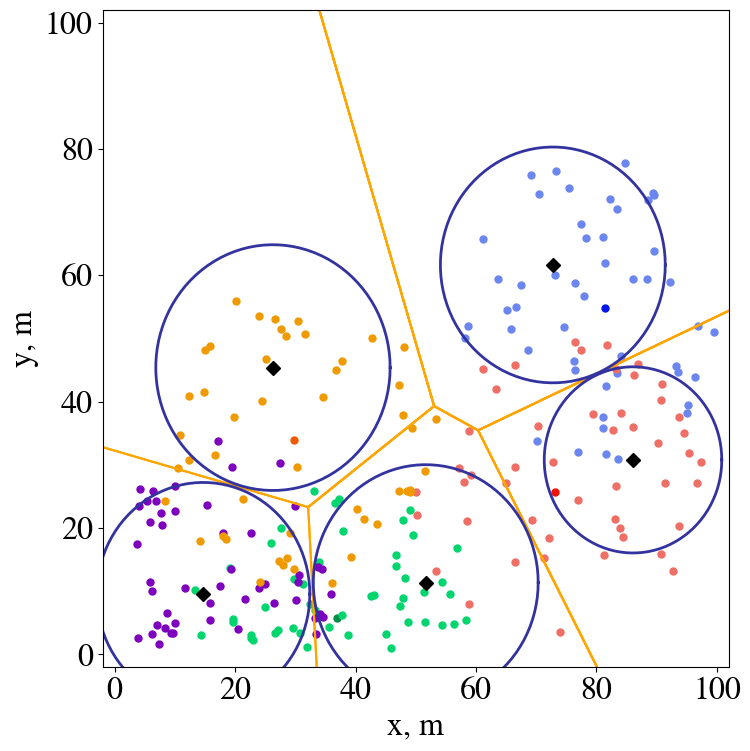

In [131]:
plt.figure(figsize=(8, 8), dpi=100)

users = simulation.users
groups = simulation.groups
drones = simulation.drones
regions = simulation.drones_diagrams

for g in range(len(groups)):
    plt.plot(users[time_step, groups[g][0], 0], users[time_step, groups[g][0], 1], '.', markersize=10, color=colors[g][0])
    plt.plot(users[time_step, groups[g][1:], 0], users[time_step, groups[g][1:], 1], '.', markersize=10, color=colors[g][1])

drones_xs = drones[time_step, :, 0]
drones_ys = drones[time_step, :, 1]
plt.plot(drones_xs, drones_ys, 'kD', markersize=7)


for d in range(len(regions[time_step])):
    if d == 0:
        dd = range(2, len(regions[time_step][d]))
    else:
        dd = range(len(regions[time_step][d]))
    for d2 in dd:
        for d3 in range(len(regions[time_step][d][d2])):
            xx = [x[0] for x in regions[time_step][d][d2]]
            yy = [y[1] for y in regions[time_step][d][d2]]
            plt.plot(xx, yy, color='orange')

            
#for ii in range(len(drones_xs)):
#    drones_x = drones_xs[ii] + radius * np.cos(angles)
#    drones_y = drones_ys[ii] + radius * np.sin(angles)
#    plt.plot(drones_x, drones_y, '#3333a0', linestyle='-', lw=2.)

drones_x = drones_xs[0] + radius * np.cos(angles) * 0.9
drones_y = drones_ys[0] + radius * np.sin(angles) * 0.9
plt.plot(drones_x, drones_y, '#3333a0', linestyle='-', lw=2.)

drones_x = drones_xs[1] + radius * np.cos(angles) * 0.95
drones_y = drones_ys[1] + radius * np.sin(angles) * 0.95
plt.plot(drones_x, drones_y, '#3333a0', linestyle='-', lw=2.)

drones_x = drones_xs[2] + radius * np.cos(angles) * 0.75
drones_y = drones_ys[2] + radius * np.sin(angles) * 0.75
plt.plot(drones_x, drones_y, '#3333a0', linestyle='-', lw=2.)

drones_x = drones_xs[3] + radius * np.cos(angles) * 0.95
drones_y = drones_ys[3] + radius * np.sin(angles) * 0.95
plt.plot(drones_x, drones_y, '#3333a0', linestyle='-', lw=2.)

drones_x = drones_xs[4] + radius * np.cos(angles) * 0.99
drones_y = drones_ys[4] + radius * np.sin(angles) * 0.99
plt.plot(drones_x, drones_y, '#3333a0', linestyle='-', lw=2.)
    
plt.xlim(-2, 102)
plt.ylim(-2, 102)
plt.xlabel('x, m')
plt.ylabel('y, m')
plt.xticks([0, 20, 40, 60, 80, 100])
plt.yticks([0, 20, 40, 60, 80, 100])
# plt.legend()
        
    
plt.tight_layout()

plt.savefig('kmeans_regions.png', dpi=600)
plt.show()